# Part1 : Data wrangling

## Data Download and pre-processing

programmatically download all the sample files from 2005 onwards

In [2]:
import requests
from robobrowser import RoboBrowser
from bs4 import BeautifulSoup
import re
from lxml import html
import pathlib
import time
import zipfile
from io import BytesIO
import pandas as pd
import glob
import os
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import missingno as msno
from matplotlib import pyplot as plt
import seaborn as sns

# plotly
import plotly.graph_objs as go
from IPython.display import HTML
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

%matplotlib inline

In [12]:
filepath = './zipfile'
#creating the folder for zipfiles
pathlib.Path(filepath).mkdir(parents=True, exist_ok=True) 

#account parameters
username = 'xinglongjia715@gmail.com'
password = 'vKTk_;<J'

# username = input('Please enter your username: ')
# password = input('Please enter your password: ')

#Intializing browser
br = RoboBrowser()
#open website
br.open('https://freddiemac.embs.com/FLoan/secure/login.php?pagename=download')  

#Getting form from browser
form = br.get_form()
form['username'] = username
form['password'] = password
br.submit_form(form)

#accept the form
form1 = br.get_form()
form1['accept'] = 'Yes'
br.submit_form(form1)

#get all the file links and cookie
links = br.find_all('a')
cookie = br.session.cookies.get_dict()
cookie

{'PHPSESSID': 'pskropv7ekk8phpime33cgs3b4'}

In [13]:
# set the headers for origination and performance data
header_perf = ['seq_no', 'MM_report', 'act_UPB','delinquency','load_age','MM_remain','repurch','modify',
              'zero_code','zero_date','interest_rate','defer_UPB','DDLPI','MI_recover','sale_proceed','Non_MI_recover',
              'expense','legal_cost','mainten','tax','mix_expense','loss','modify_cost','step_modify','defer_modify','ELTV']
header_orig = ['score','pay1_date','homebuyer','maturity_date','MSA','MI%','unit','occupancy','CLTV','DTI_rat','UPB','LTV',
               'interest_rate','channel','PPM','prod_type','prop_state','prop_type','post_code','seq_no','purpose','term',
              'borrowers','seller','service','sup_conform']

for link in links:
    regex = re.findall('sample_\d+.zip', str(link))
    if(regex and (int)(re.findall('\d+', str(regex))[0]) > 2005):
        #download zip file
        url = "https://freddiemac.embs.com/FLoan/Data/" + link.get('href')
        year = regex[0].split('_')[1][:4]
        print(year,'|',url)
        content = requests.get(url, cookies = cookie) 
        zf = zipfile.ZipFile(BytesIO(content.content))
        #download txt file, add headers, convert to csv and save in zipfile directory
        for name in zf.namelist():
            if re.findall('svcg',name):
                df = pd.read_csv(zf.open(name), sep='|', header=None)
                df.to_csv(filepath+'/'+str(year)+'_perf.csv',index=False, header=header_perf)
            if re.findall('orig',name):
                df = pd.read_csv(zf.open(name), sep='|', header=None)
                df.to_csv(filepath+'/'+str(year)+'_orig.csv',index=False, header=header_orig)

2006 | https://freddiemac.embs.com/FLoan/Data/download.php?f=sample_2006&s=33286483
2007 | https://freddiemac.embs.com/FLoan/Data/download.php?f=sample_2007&s=31029360
2008 | https://freddiemac.embs.com/FLoan/Data/download.php?f=sample_2008&s=25243310
2009 | https://freddiemac.embs.com/FLoan/Data/download.php?f=sample_2009&s=29742643
2010 | https://freddiemac.embs.com/FLoan/Data/download.php?f=sample_2010&s=29502562
2011 | https://freddiemac.embs.com/FLoan/Data/download.php?f=sample_2011&s=27895583
2012 | https://freddiemac.embs.com/FLoan/Data/download.php?f=sample_2012&s=31533051
2013 | https://freddiemac.embs.com/FLoan/Data/download.php?f=sample_2013&s=26626765
2014 | https://freddiemac.embs.com/FLoan/Data/download.php?f=sample_2014&s=20459253
2015 | https://freddiemac.embs.com/FLoan/Data/download.php?f=sample_2015&s=17376778
2016 | https://freddiemac.embs.com/FLoan/Data/download.php?f=sample_2016&s=12007433
2017 | https://freddiemac.embs.com/FLoan/Data/download.php?f=sample_2017&s=4

Create summary files for origination and performance data

In [50]:
# file path of the summary of origination and performance data
orig_summary = './summary/orig.csv'
perf_summary = './summary/perf.csv'

# check the summary directory
if not os.path.exists('./summary'):
    os.mkdir('./summary')

for csv_name in glob.glob("./zipfile/*.csv"):
    # aggregate origination summary
    if re.findall('orig', csv_name):
        year = re.findall('\d+',csv_name)[0]
        df = pd.read_csv(csv_name)
        metrix = df.describe().T.dropna()
        metrix['year'] = year
        if not os.path.exists(orig_summary):
            metrix.to_csv(orig_summary)
        else:
            metrix.to_csv(orig_summary,mode='a',header=False)
    # aggregate performance summary
    if re.findall('perf', csv_name):
        year = re.findall('\d+',csv_name)[0]
        df = pd.read_csv(csv_name)
        metrix = df.describe().T.dropna()
        metrix['year'] = year
        if not os.path.exists(perf_summary):
            metrix.to_csv(perf_summary)
        else:
            metrix.to_csv(perf_summary,mode='a',header=False)

# trends over time
summary_orig = pd.read_csv(orig_summary)
summary_orig.rename(columns={'Unnamed: 0':'attribute'}, inplace=True)
summary_orig.groupby(['attribute','year']).mean().to_csv('./summary/orig_year.csv')

summary_perf = pd.read_csv(perf_summary)
summary_perf.rename(columns={'Unnamed: 0':'attribute'}, inplace=True)
summary_perf.groupby(['attribute','year']).mean().to_csv('./summary/perf_year.csv')

## Explotatory Data analysis

Represent different summaries of data

Take numerical parameters mean and store summary in perf_quart and orig_quart

In [14]:
years = ['07','08','09']
perf_quart = './summary/perf_quart.csv'
orig_quart = './summary/orig_quart.csv'

for year in years:
    print(year)
    
    df_perf=pd.read_csv('./zipfile/20'+ year +'_perf.csv')
    for j in range(1,5):
        df_perf['seq_no'] = df_perf['seq_no'].str.replace('F1'+year+'Q'+str(j)+'\d+',year+'Q'+str(j))
    if year == '07':
        df_perf.groupby('seq_no').mean().to_csv(perf_quart)
    else:
        df_perf.groupby('seq_no').mean().to_csv(perf_quart, mode='a',header=False)
    
    df_orig=pd.read_csv('./zipfile/20'+ year +'_orig.csv')
    for j in range(1,5):
        df_orig['seq_no'] = df_orig['seq_no'].str.replace('F1'+year+'Q'+str(j)+'\d+',year+'Q'+str(j))
    if year == '07':
        df_orig.groupby('seq_no').mean().to_csv(orig_quart)
    else:
        df_orig.groupby('seq_no').mean().to_csv(orig_quart, mode='a',header=False)

07
08
09


store data after grouped by quarters

In [3]:
years = ['07','08','09']
perf_list = []
orig_list = []
for year in years:
    print(year)
    df_perf=pd.read_csv('./zipfile/20'+ year +'_perf.csv')
    for j in range(1,5):
        df_perf['seq_no'] = df_perf['seq_no'].str.replace('F1'+year+'Q'+str(j)+'\d+',year+'Q'+str(j))
    perf_list.append(df_perf)
    df_orig=pd.read_csv('./zipfile/20'+ year +'_orig.csv')
    for j in range(1,5):
        df_orig['seq_no'] = df_orig['seq_no'].str.replace('F1'+year+'Q'+str(j)+'\d+',year+'Q'+str(j))
    orig_list.append(df_orig)

07
08
09


### Categorical parameters

#### Delinquency status

In [5]:
perf_list[0].select_dtypes(include = 'object').columns

Index(['seq_no', 'delinquency', 'repurch', 'modify', 'sale_proceed',
       'step_modify', 'defer_modify'],
      dtype='object')

In [4]:
df1 = perf_list[0].groupby(['seq_no','delinquency']).size().unstack().T.sort_values(by='07Q1',ascending=False).ix[:12].reset_index()
df2 = perf_list[1].groupby(['seq_no','delinquency']).size().unstack().T.sort_values(by='08Q1',ascending=False).ix[:12].reset_index()
df3 = perf_list[2].groupby(['seq_no','delinquency']).size().unstack().T.sort_values(by='09Q1',ascending=False).ix[:12].reset_index()
df = pd.merge(df1,df2,on='delinquency')
df = pd.merge(df,df3,on='delinquency')
df = df.dropna(axis=1)
df = df.T.drop(df.T.index[0]).reset_index()
df_all = perf_list[0].groupby('seq_no').size().append(perf_list[1].groupby('seq_no').size()).append(perf_list[2].groupby('seq_no').size())
df_all = df_all.reset_index().drop([8]).rename(columns={ df.columns[1]: "all" })
df = pd.merge(df,df_all,on='seq_no')
df

,seq_no,0,1,2,3,4,5,6,7,8,9,all
0,07Q1,683740,20818,7101,3657,2831,2419,1978,1772,1548,1362,742881
1,07Q2,666030,22424,8351,4182,3088,2575,2089,1812,1662,1486,730901
2,07Q3,578140,21084,7872,3965,3063,2600,2171,1851,1634,1474,639798
3,07Q4,592863,22742,8476,4372,3399,2829,2394,2137,1843,1659,661076
4,08Q1,601542,15953,5589,2738,2039,1740,1504,1250,1096,978,644985
5,08Q2,530532,13097,4830,2300,1783,1507,1275,1134,1004,890,601724
6,08Q3,461182,12994,4548,2128,1548,1345,1150,1011,878,775,495667
7,08Q4,461537,9934,3270,1453,1049,900,727,653,552,466,521972
8,09Q1,582143,3733,787,392,325,265,217,182,169,148,634856
9,09Q2,475113,2451,679,272,225,158,125,103,91,76,697155


In [5]:
trace = []
for i in df.columns[1:-1]:
    temp = go.Scatter(x=df['seq_no'],y=df[i]/df['all']*100,mode='lines+markers',name=str(i))
    trace.append(temp)
data = trace[:]
layout = dict(title='Delinquency Status',
             xaxis = dict(title='Quarters'),
             yaxis = dict(title='Percentage %'))
iplot(dict(data = data, layout =layout))

Delinquency status, nearly all of them is status 0, which is current or less than 30 days, and the percentage of the top 10 status decrease a little.

#### postal code

In [18]:
df1 = orig_list[0].groupby(['seq_no','post_code']).size().unstack().T.sort_values(by='07Q1',ascending=False).reset_index().ix[:30]
df2 = orig_list[1].groupby(['seq_no','post_code']).size().unstack().T.sort_values(by='08Q1',ascending=False).reset_index().ix[:30]
df3 = orig_list[2].groupby(['seq_no','post_code']).size().unstack().T.sort_values(by='09Q1',ascending=False).reset_index().ix[:30]
df = pd.merge(df1,df2,on='post_code')
df = pd.merge(df,df3,on='post_code')
df_post_code = df.dropna(thresh=2,axis=1)
df_post_code = df_post_code.dropna()
#df_post_code.T.drop(df.T.index[0]).reset_index()
dfT = df_post_code.T
dfT.columns = dfT.iloc[0]
df_code = dfT.reset_index().drop([0])
df_code

post_code,seq_no,75000.0,30000.0,60100.0,84000.0,85200.0,60600.0,60000.0,98000.0,60500.0,60400.0,55300.0,97200.0,63100.0,28200.0
1,07Q1,123.0,118.0,106.0,98.0,97.0,97.0,93.0,89.0,85.0,73.0,67.0,64.0,53.0,53.0
2,07Q2,110.0,118.0,85.0,103.0,93.0,110.0,79.0,48.0,71.0,97.0,57.0,52.0,46.0,62.0
3,07Q3,122.0,101.0,88.0,88.0,83.0,116.0,105.0,62.0,69.0,87.0,66.0,43.0,56.0,61.0
4,07Q4,78.0,104.0,97.0,144.0,83.0,149.0,109.0,74.0,59.0,96.0,51.0,67.0,73.0,58.0
5,08Q1,105.0,94.0,130.0,128.0,86.0,159.0,140.0,107.0,88.0,85.0,57.0,69.0,59.0,64.0
6,08Q2,108.0,128.0,107.0,111.0,100.0,151.0,110.0,85.0,85.0,88.0,61.0,71.0,58.0,51.0
7,08Q3,104.0,115.0,83.0,95.0,83.0,145.0,127.0,72.0,72.0,69.0,45.0,44.0,53.0,44.0
8,08Q4,98.0,107.0,109.0,146.0,83.0,144.0,127.0,91.0,80.0,68.0,58.0,63.0,63.0,41.0
9,09Q1,84.0,128.0,119.0,140.0,76.0,135.0,156.0,103.0,103.0,76.0,83.0,64.0,73.0,62.0
10,09Q2,78.0,97.0,107.0,102.0,76.0,110.0,124.0,92.0,91.0,70.0,68.0,82.0,63.0,37.0


In [19]:
trace = []
for i in df_code.columns[1:]:
    temp = go.Scatter(x=df_code['seq_no'],y=df_code[i],mode='lines+markers',name=str(i))
    trace.append(temp)
data = trace[:]
layout = dict(title='Postal code',
             xaxis = dict(title='Quarters'),
             yaxis = dict(title='Counts'))
iplot(dict(data = data, layout =layout))

select out most common 14 postal code and check its trend over quarters. No significant change, move up and down in small range.

#### Property state

In [20]:
df1 = orig_list[0].groupby(['seq_no','prop_state']).size().unstack().T.reset_index()
df2 = orig_list[1].groupby(['seq_no','prop_state']).size().unstack().T.reset_index()
df3 = orig_list[2].groupby(['seq_no','prop_state']).size().unstack().T.reset_index()
df = pd.merge(df1,df2,on='prop_state')
df = pd.merge(df,df3,on='prop_state')
df_state = df.dropna(thresh=2,axis=1)
df_state

seq_no,prop_state,07Q1,07Q2,07Q3,07Q4,08Q1,08Q2,08Q3,08Q4,09Q1,09Q2,09Q3,09Q4
0,AK,29.0,35.0,35.0,34.0,30.0,30.0,45.0,30.0,39.0,42.0,43.0,31.0
1,AL,195.0,178.0,204.0,171.0,165.0,160.0,185.0,171.0,136.0,122.0,106.0,130.0
2,AR,118.0,140.0,147.0,113.0,71.0,81.0,94.0,83.0,73.0,62.0,70.0,76.0
3,AZ,378.0,344.0,334.0,346.0,285.0,320.0,306.0,303.0,213.0,230.0,264.0,242.0
4,CA,922.0,846.0,776.0,1207.0,1251.0,1406.0,1440.0,1623.0,1270.0,1341.0,1570.0,1749.0
5,CO,268.0,248.0,261.0,297.0,251.0,290.0,323.0,347.0,386.0,370.0,340.0,342.0
6,CT,137.0,145.0,138.0,121.0,150.0,143.0,120.0,119.0,134.0,162.0,172.0,156.0
7,DC,13.0,14.0,20.0,19.0,29.0,32.0,19.0,31.0,30.0,21.0,28.0,24.0
8,DE,28.0,52.0,50.0,45.0,36.0,44.0,49.0,47.0,37.0,42.0,59.0,53.0
9,FL,848.0,808.0,767.0,741.0,631.0,691.0,642.0,590.0,321.0,349.0,456.0,430.0


In [21]:
scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]
quarters = ['07Q1','07Q2','07Q3','07Q4','08Q1','08Q2','08Q3','08Q4','09Q1','09Q2','09Q3','09Q4']
data_bal = []

data_07Q1 = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df_state['prop_state'],
        z = df_state['07Q1'],
        locationmode = 'USA-states',
        
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        visible= True,
        colorbar = dict(
            title = "Counts")
        ) ]

data_bal.extend(data_07Q1)

for i in quarters[1:]:
    data = [ dict(
            type='choropleth',
            colorscale = scl,
            autocolorscale = False,
            locations = df_state['prop_state'],
            z = df_state[i],
            locationmode = 'USA-states',
            
            marker = dict(
                line = dict (
                    color = 'rgb(255,255,255)',
                    width = 2
                ) ),
            visible = False,
            colorbar = dict(
                title = "Counts")
            ) ]
    data_bal.extend(data)
    
# set menues inside the plot
steps = []
quart = 0
for i in range(0,len(data_bal)):
    step = dict(method = "restyle",
                args = ["visible", [False]*len(data_bal)],
                label = quarters[quart]) 
    step['args'][1][i] = True
    steps.append(step)
    quart += 1

sliders = [dict(active = 10,
                currentvalue = {"prefix": "Quarter: "},
                pad = {"t": 50},
                steps = steps)]

layout = dict(
        title = 'Location postal code counts vs Quarters',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
        sliders = sliders
             )
iplot(dict(data = data_bal, layout =layout))

### Numerical parameters

In [118]:
quart_perf = pd.read_csv(perf_quart).drop([8])
quart_perf

,seq_no,MM_report,act_UPB,load_age,MM_remain,zero_code,zero_date,interest_rate,defer_UPB,DDLPI,MI_recover,Non_MI_recover,expense,legal_cost,mainten,tax,mix_expense,loss,modify_cost,ELTV
0,07Q1,201023.758392,162259.993490,41.413474,304.253440,1.654497,201108.460730,6.068712,629.687322,201113.114094,9423.990901,7274.507734,-15464.832575,-3325.674249,-4863.333940,-6503.007279,-772.867152,-87419.571429,1488.721214,58.635238
1,07Q2,201043.729178,159202.340248,41.024016,308.158285,1.697978,201118.454742,6.143420,816.888495,201115.687699,13314.777583,8896.843257,-14877.065674,-3339.241681,-4437.720665,-6320.399299,-779.715412,-80246.749562,1724.325769,61.596764
2,07Q3,201049.028775,153814.140957,38.609094,312.027867,1.706445,201087.665545,6.480614,930.797238,201118.454661,16956.899382,8510.387467,-15213.235658,-3307.965578,-4781.406884,-6376.191527,-747.692851,-79964.000883,1861.906137,64.141357
3,07Q4,201075.398376,165564.497659,38.568142,308.367241,1.769059,201124.385645,6.160130,1011.097909,201137.491495,17584.183575,14028.657005,-15834.512077,-3395.301932,-4350.038647,-7373.925121,-715.279388,-82880.366345,2198.361613,62.251987
4,08Q1,201081.575554,173861.820922,36.359492,294.586279,1.467062,201143.006897,5.772004,702.909706,201158.331502,13466.922061,12081.126816,-15082.441215,-3115.602378,-4416.583884,-6842.445178,-707.840159,-80358.228534,1262.168313,55.390067
5,08Q2,201095.945448,168962.635923,35.422845,299.451504,1.393996,201134.095302,5.941348,431.609128,201181.422764,14030.481054,11929.774300,-17023.995058,-3413.154860,-4898.744646,-8055.235585,-656.917628,-78132.293245,950.800212,53.572985
6,08Q3,201105.671919,162074.026191,33.529313,308.451773,1.359285,201097.287533,6.304311,449.724124,201169.639816,13330.148008,10605.614801,-13984.436433,-3223.755218,-4987.127135,-6518.227704,744.647059,-69579.265655,1118.386489,53.930304
7,08Q4,201129.533789,173184.967060,32.973387,311.453432,1.199806,201135.419945,5.835992,437.170021,201259.995106,9912.375394,12186.832808,-15744.757098,-3140.854890,-5085.495268,-7170.501577,-347.996845,-67982.511041,727.053146,51.577155
9,09Q1,201162.965411,185548.940945,34.124198,293.259383,1.066281,201218.194153,4.910656,11.216994,201289.304000,8539.517544,7332.043860,-14692.192982,-3447.175439,-5685.745614,-6122.026316,562.684211,-69222.763158,28.550582,44.424204
10,09Q2,201205.215195,179551.458288,36.403184,283.830521,1.040129,201265.989748,4.830470,13.398900,201392.258621,3293.576271,9138.627119,-19453.779661,-3657.118644,-6315.915254,-8461.932203,-1018.881356,-63974.491525,18.408116,42.969081


In [182]:
def quart_plot(attribute, data):
   
    plt.plot(data['seq_no'],data[attribute],marker='o')
    plt.title('Trends over quarters for '+ attribute)
    plt.ylabel(attribute)
    plt.xlabel('quarters')
    plt.grid(True)

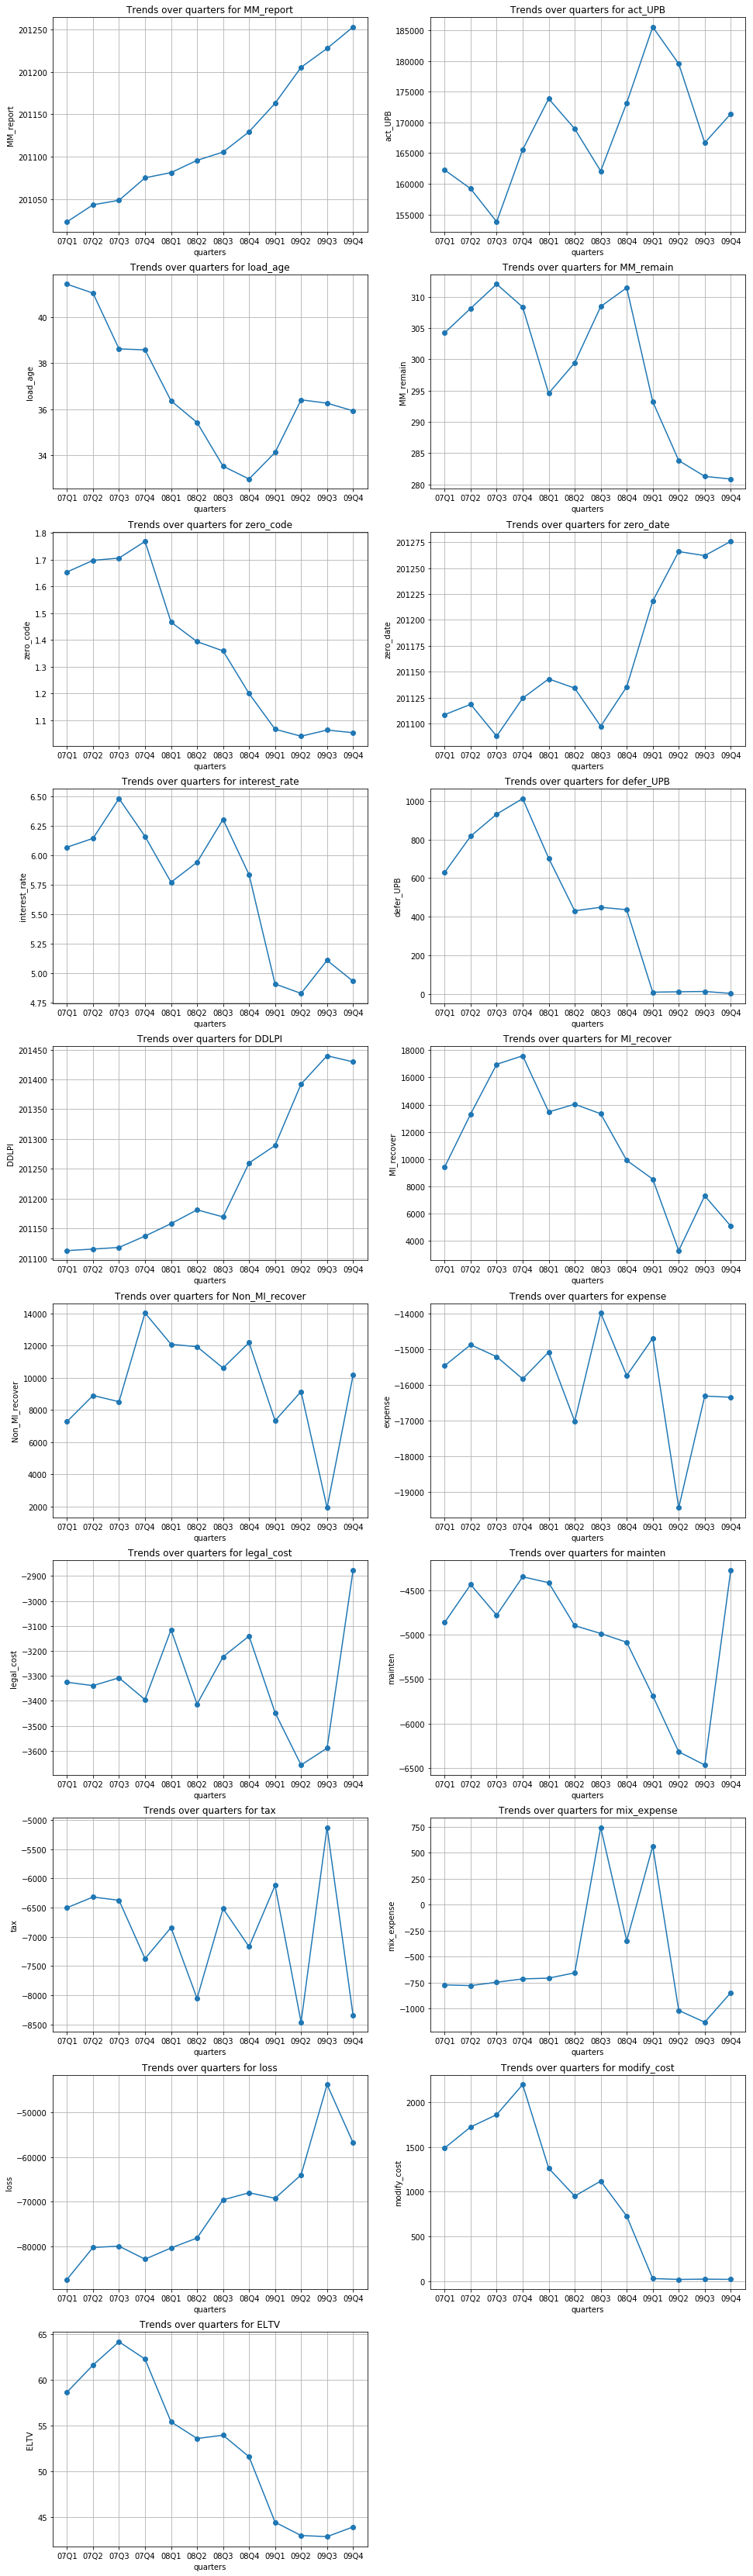

In [189]:
plt.figure(figsize=(16,60))
for i,col in enumerate(quart_perf.columns[1:]):
    plt.subplot(10,2,i+1)
    quart_plot(col,quart_perf)

In [121]:
quart_orig = pd.read_csv(orig_quart).drop([8]).dropna(axis=1)
quart_orig

,seq_no,score,pay1_date,maturity_date,MSA,MI%,unit,CLTV,DTI_rat,UPB,LTV,interest_rate,post_code,term,borrowers
0,07Q1,730.92184,200704.41608,203532.564160,30043.988506,3.572240,1.032400,73.502720,53.944800,184223.040000,70.61472,6.199913,50798.880000,339.501360,1.581520
1,07Q2,729.26544,200707.70520,203551.401840,29835.059569,4.787200,1.031760,75.154800,59.019360,181669.440000,72.09880,6.297054,50625.816000,341.378240,1.591360
2,07Q3,726.15128,200711.28152,203566.847360,29597.030571,6.369760,1.035360,75.875360,65.000880,177970.800000,73.49232,6.661723,50467.880000,342.800080,1.565440
3,07Q4,727.50760,200771.67552,203561.668880,30276.968735,6.032960,1.047120,73.622720,68.537440,191193.360000,72.20856,6.349118,52753.168000,337.940560,1.565280
4,08Q1,736.08896,200804.32088,203518.305360,30333.703067,4.172560,1.036880,71.093280,62.963840,203430.720000,69.54736,5.870839,52403.744000,325.812640,1.624080
5,08Q2,745.36336,200807.29576,203569.422080,30262.694263,4.493280,1.038960,71.162080,60.398400,202383.040000,69.82904,6.024245,53178.744000,331.580720,1.531040
6,08Q3,745.15032,200811.00672,203640.373600,30132.513614,4.834160,1.042160,72.658560,56.566800,198776.880000,71.63224,6.420653,53552.360000,339.657120,1.540160
7,08Q4,758.87455,200870.36891,203695.916713,30589.653900,3.572686,1.028642,71.103848,48.809585,211323.945916,70.11921,5.912388,53910.360829,341.419074,1.564845
9,09Q1,762.79328,200904.15544,203626.177840,29716.565517,1.564560,1.010320,66.338640,36.915200,219970.480000,64.85120,4.937770,52142.848000,326.782400,1.648800
10,09Q2,766.45008,200907.07712,203561.079760,30127.665314,1.319040,1.014640,65.662080,32.965200,215302.000000,64.13288,4.848927,51413.512000,318.609680,1.659760


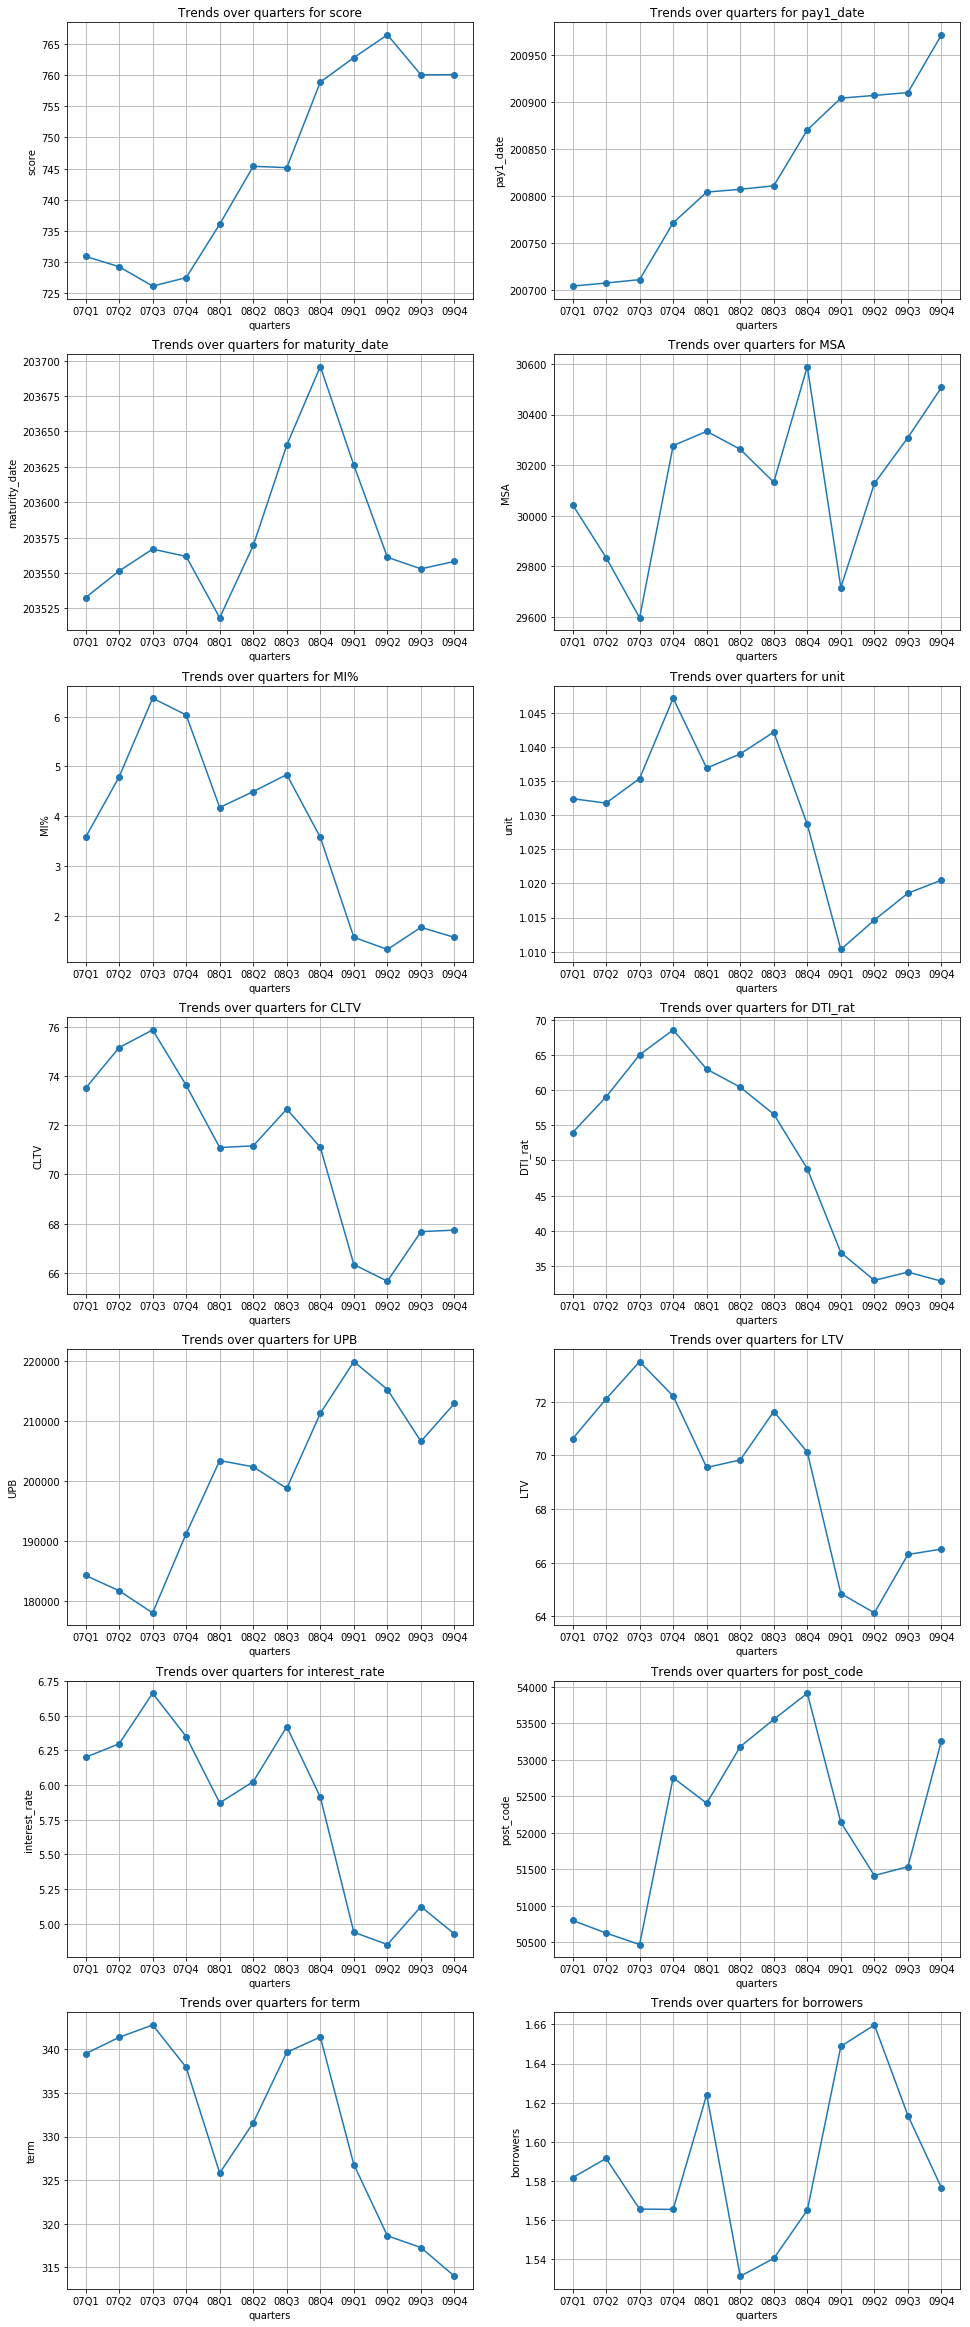

In [190]:
plt.figure(figsize=(16,60))
for i,col in enumerate(quart_orig.columns[1:]):
    plt.subplot(10,2,i+1)
    quart_plot(col,quart_orig)
        

### Single year summaries of data(2007)

### summary metrix

In [6]:
df_perf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2774656 entries, 0 to 2774655
Data columns (total 26 columns):
seq_no            object
MM_report         int64
act_UPB           float64
delinquency       object
load_age          int64
MM_remain         int64
repurch           object
modify            object
zero_code         float64
zero_date         float64
interest_rate     float64
defer_UPB         float64
DDLPI             float64
MI_recover        float64
sale_proceed      object
Non_MI_recover    float64
expense           float64
legal_cost        float64
mainten           float64
tax               float64
mix_expense       float64
loss              float64
modify_cost       float64
step_modify       object
defer_modify      object
ELTV              float64
dtypes: float64(16), int64(3), object(7)
memory usage: 550.4+ MB


In [97]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 26 columns):
score            50000 non-null int64
pay1_date        50000 non-null int64
homebuyer        50000 non-null object
maturity_date    50000 non-null int64
MSA              41791 non-null float64
MI%              50000 non-null int64
unit             50000 non-null int64
occupancy        50000 non-null object
CLTV             50000 non-null int64
DTI_rat          50000 non-null int64
UPB              50000 non-null int64
LTV              50000 non-null int64
interest_rate    50000 non-null float64
channel          50000 non-null object
PPM              49936 non-null object
prod_type        50000 non-null object
prop_state       50000 non-null object
prop_type        50000 non-null object
post_code        50000 non-null int64
seq_no           50000 non-null object
purpose          50000 non-null object
term             50000 non-null int64
borrowers        50000 non-null int64
sell

#### visualize missing dara

missingno provides a small toolset of flexible and easy-to-use missing data visualizations and utilities that allows you to get a quick visual summary of the completeness (or lack thereof) of your dataset. 

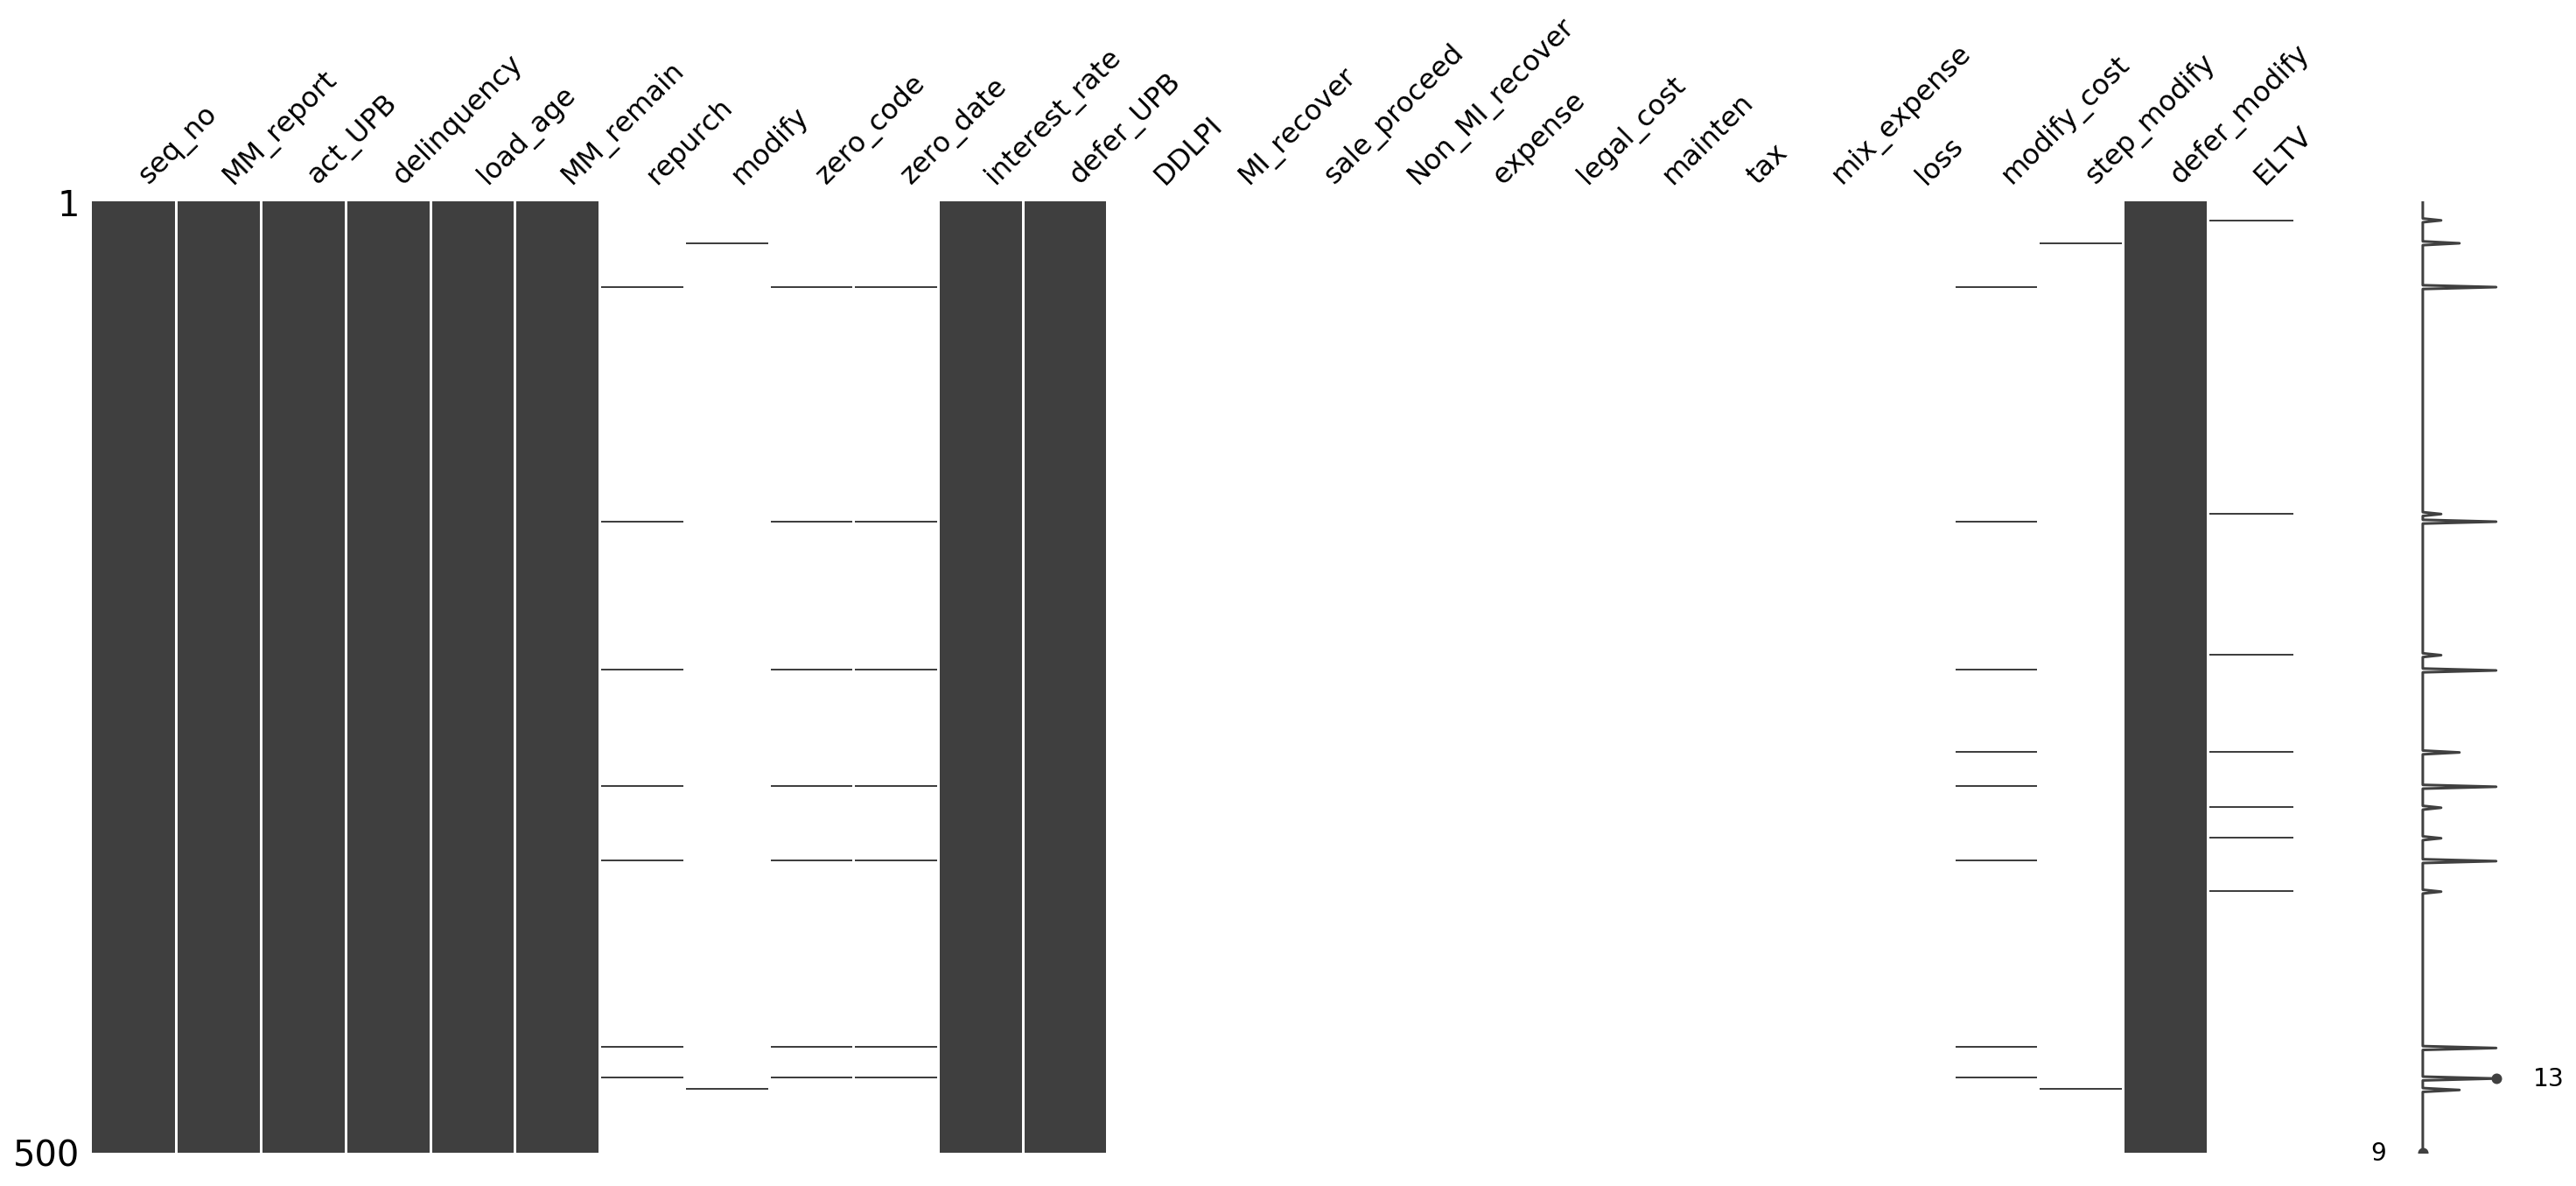

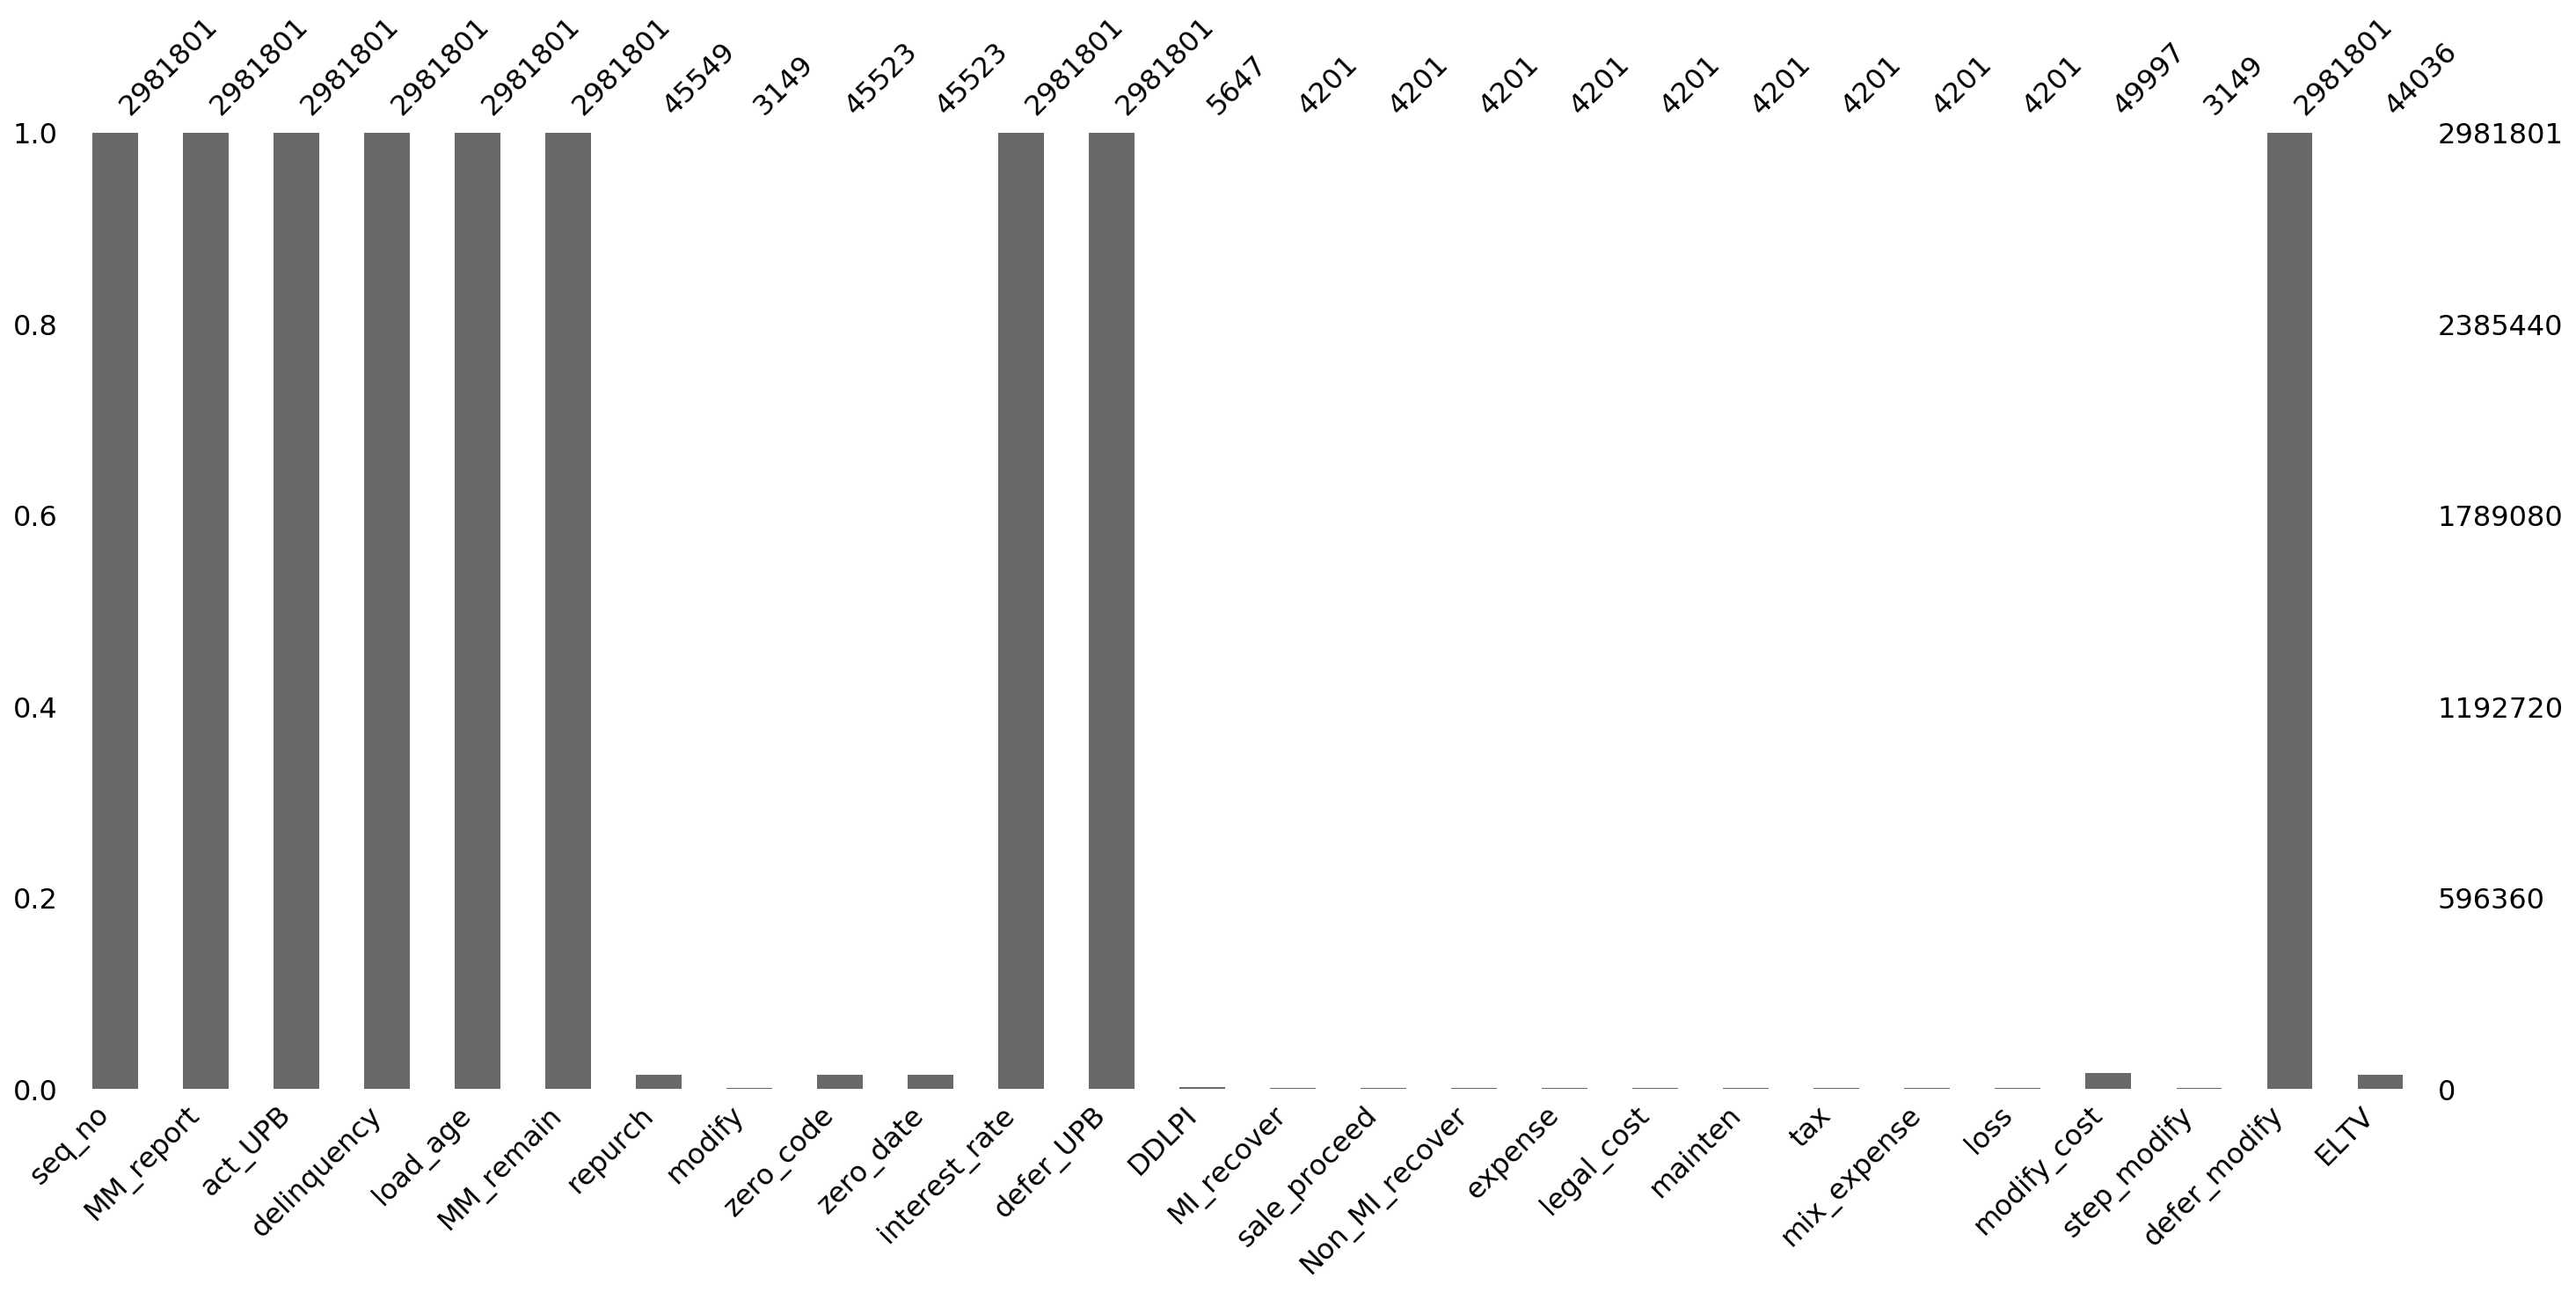

In [29]:
msno.matrix(df_perf.sample(500))
msno.bar(df_perf)

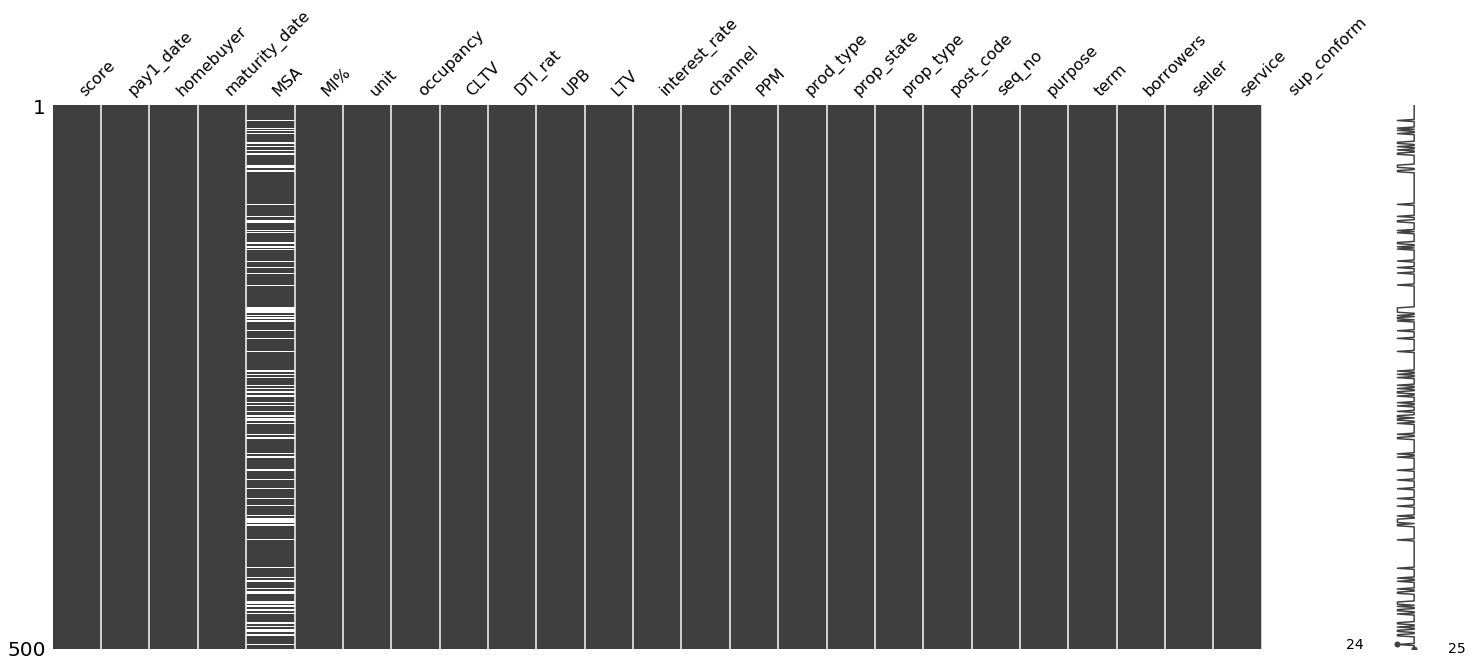

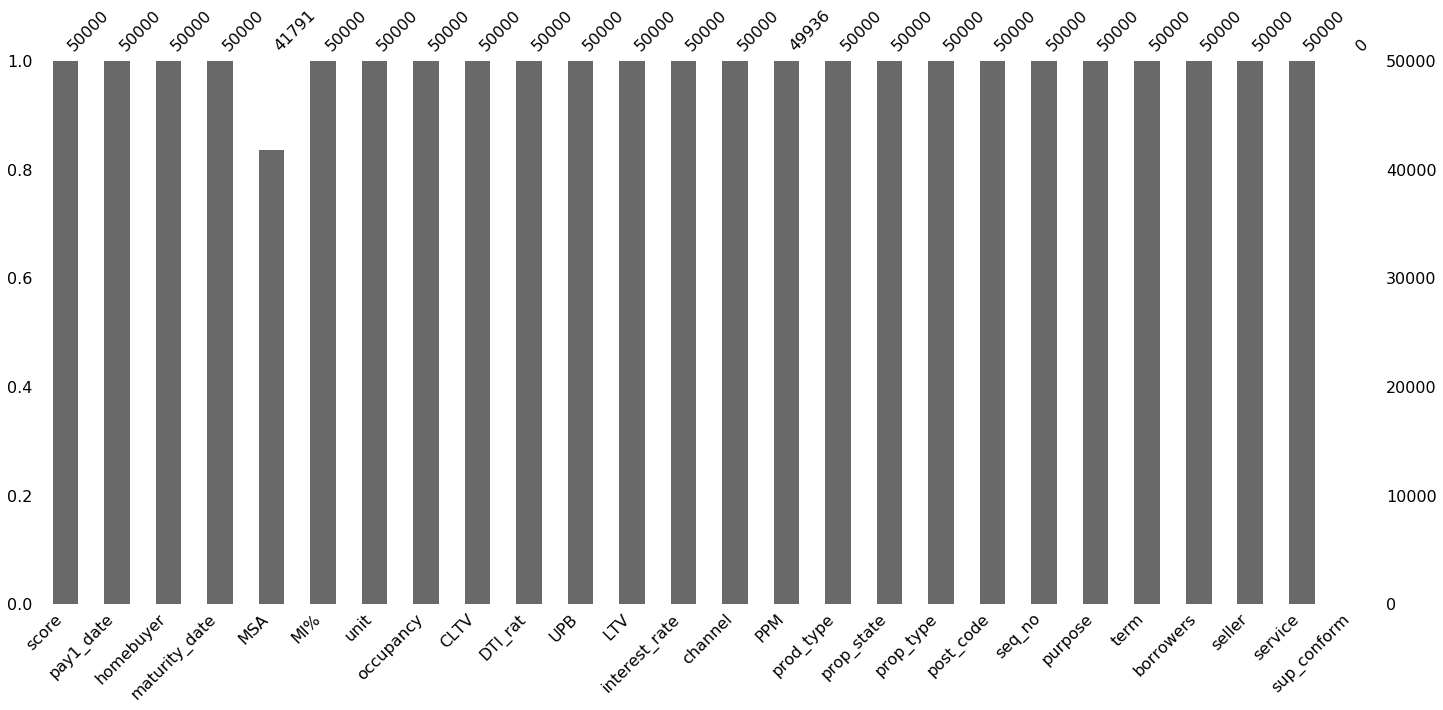

In [15]:
msno.matrix(df_orig.sample(500))
msno.bar(df_orig)

#### numerical attributes

In [95]:
metrix = df_perf.describe().T.dropna()
metrix['year'] = '2006'
print(metrix.shape)
metrix

(19, 9)


,count,mean,std,min,25%,50%,75%,max,year
MM_report,2981801.0,200970.520211,282.501479,200602.00,200711.000,200906.000,201110.000,201803.0,2006
act_UPB,2981801.0,157320.881169,92174.788874,0.00,89160.220,139511.250,209000.000,802000.0,2006
load_age,2981801.0,42.695682,33.721852,0.00,16.000,34.000,62.000,145.0,2006
MM_remain,2981801.0,299.506346,73.892356,-1.00,281.000,322.000,344.000,603.0,2006
zero_code,45523.0,1.598005,2.160102,1.00,1.000,1.000,1.000,15.0,2006
zero_date,45523.0,201049.853063,259.843339,200602.00,200901.000,201007.000,201208.000,201803.0,2006
interest_rate,2981801.0,6.270802,0.756462,0.00,6.125,6.375,6.625,50.0,2006
defer_UPB,2981801.0,638.023355,7164.401571,0.00,0.000,0.000,0.000,271000.0,2006
DDLPI,5647.0,201094.026740,305.119185,200602.00,200903.000,201007.000,201209.000,201801.0,2006
MI_recover,4201.0,9132.957153,21500.075614,0.00,0.000,0.000,0.000,139622.0,2006


In [98]:
metrix1 = df_orig.describe().T.dropna()
metrix1['year'] = '2006'
print(metrix1.shape)
metrix1

(14, 9)


,count,mean,std,min,25%,50%,75%,max,year
score,50000.0,729.955000,265.430324,300.0,681.000,728.000,772.000,9999.00,2006
pay1_date,50000.0,200623.858940,36.565234,200601.0,200606.000,200609.000,200612.000,201302.00,2006
maturity_date,50000.0,203421.272300,491.919734,201106.0,203603.000,203607.000,203610.000,205704.00,2006
MSA,41791.0,29990.752794,11360.100975,10180.0,19124.000,31140.000,39340.000,49740.00,2006
MI%,50000.0,3.476260,9.084821,0.0,0.000,0.000,0.000,40.00,2006
unit,50000.0,1.027740,0.210550,1.0,1.000,1.000,1.000,4.00,2006
CLTV,50000.0,73.131020,19.060129,6.0,63.000,79.000,86.000,999.00,2006
DTI_rat,50000.0,57.585180,141.059381,1.0,28.000,37.000,46.000,999.00,2006
UPB,50000.0,179592.580000,93860.068097,10000.0,107000.000,160000.000,235000.000,802000.00,2006
LTV,50000.0,70.713940,17.802736,6.0,62.000,78.000,80.000,999.00,2006


#### categorical attributes

In [105]:
df_perf.select_dtypes(include='object').columns

Index(['seq_no', 'delinquency', 'repurch', 'modify', 'sale_proceed',
       'step_modify', 'defer_modify'],
      dtype='object')

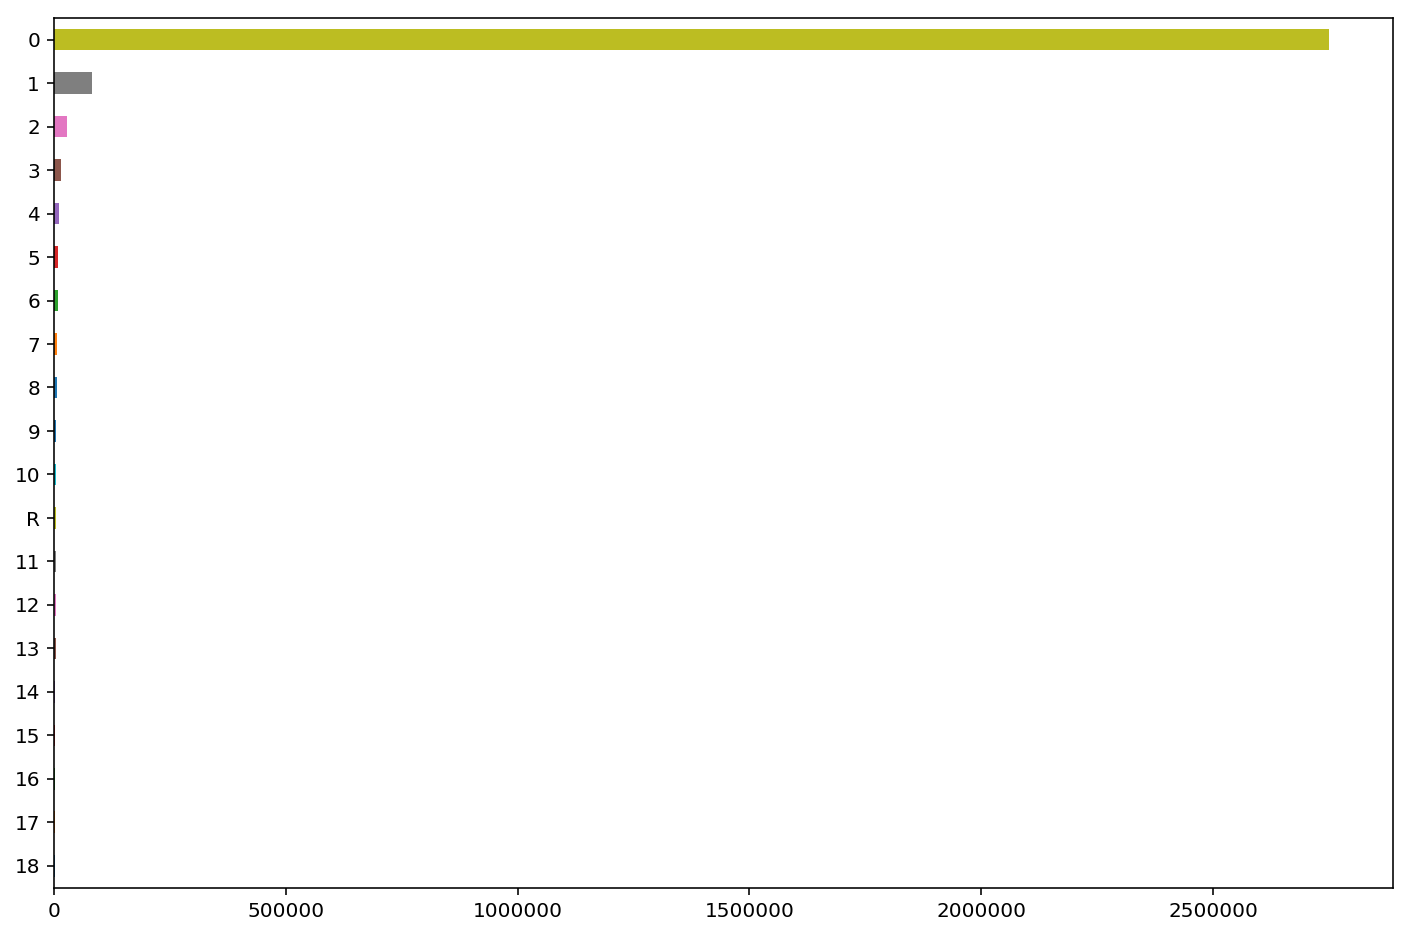

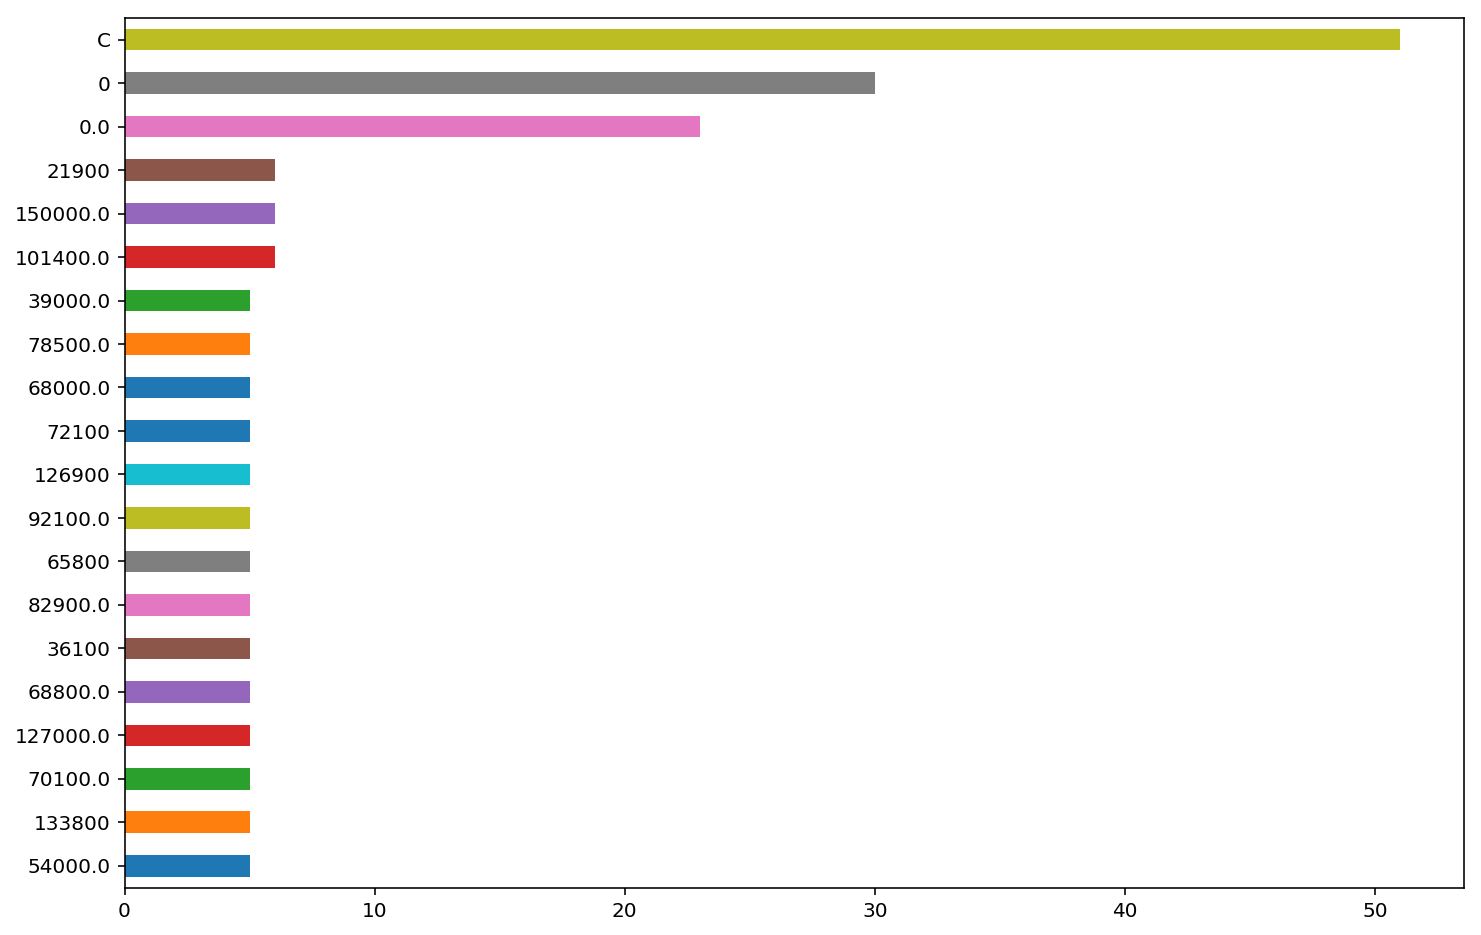

In [26]:
plt.figure(figsize=(12,8))
df_perf['delinquency'].value_counts(ascending=True)[-20:].plot(kind='barh')
plt.figure(figsize=(12,8))
df_perf['sale_proceed'].value_counts(ascending=True)[-20:].plot(kind='barh')

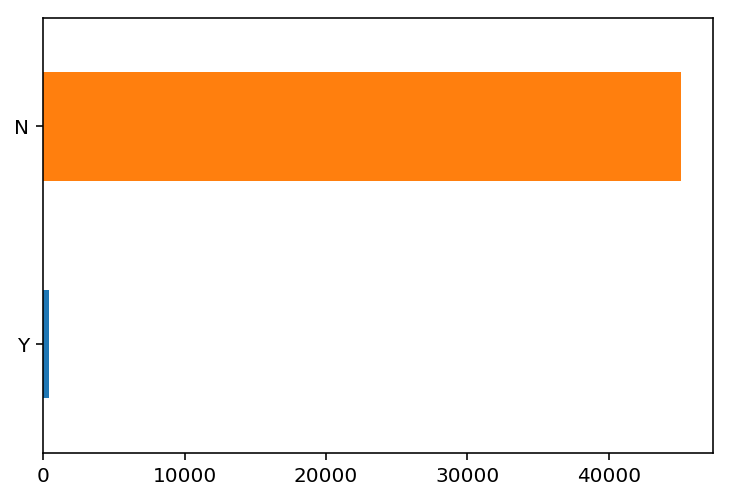

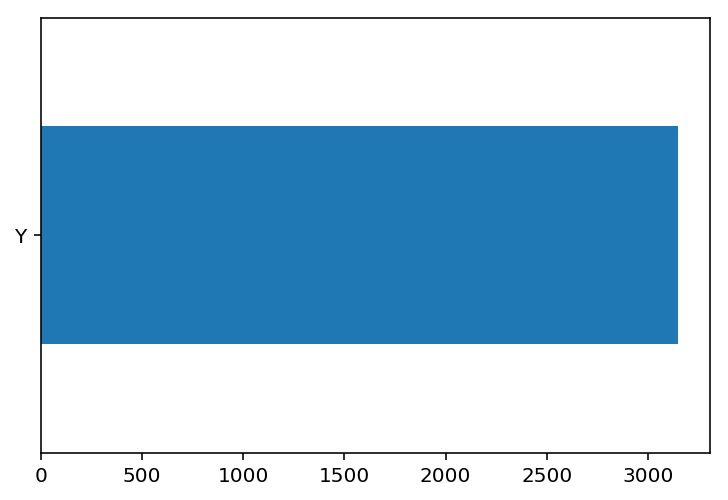

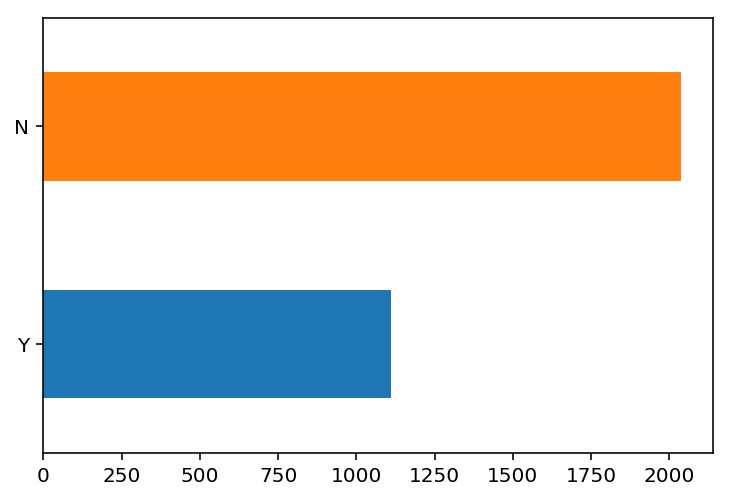

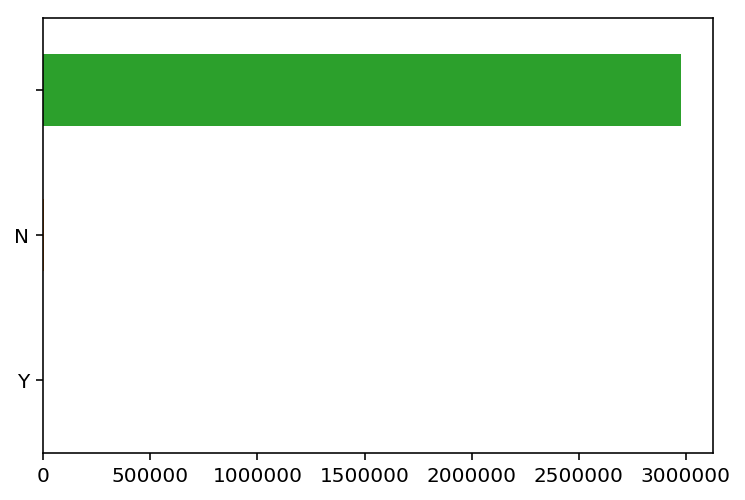

In [20]:
plt.figure()
df_perf['repurch'].value_counts(ascending=True).plot(kind='barh')
plt.figure()
df_perf['modify'].value_counts(ascending=True).plot(kind='barh')
plt.figure()
df_perf['step_modify'].value_counts(ascending=True).plot(kind='barh')
plt.figure()
df_perf['defer_modify'].value_counts(ascending=True).plot(kind='barh')